# MODELO PREDICTIVO CON SERIES DE TIEMPO



In [5]:
import finnhub
import pandas as pd
from time import mktime
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import r2_score
import numpy as np
import itertools
from scipy import stats

## ANÁLISIS EXPLORATORIO DE LOS DATOS (EDA)

In [6]:
sns.set_theme()
sns.set_context("paper")
finnhub_client = finnhub.Client(api_key="ckuiql1r01qmtr8l8dvgckuiql1r01qmtr8l8e00")

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
end_date = datetime.now()  
end = int(end_date.timestamp())
BTC_res = finnhub_client.crypto_candles('BINANCE:BTCUSDT', 'D',1502928000, end)
BTC_df = pd.DataFrame(BTC_res)
BTC_df.head()

,c,h,l,o,s,t,v
0,4285.08,4485.39,4200.74,4261.48,ok,1502928000,795.150377
1,4108.37,4371.52,3938.77,4285.08,ok,1503014400,1199.888264
2,4139.98,4184.69,3850.00,4108.37,ok,1503100800,381.309763
3,4086.29,4211.08,4032.62,4120.98,ok,1503187200,467.083022
4,4016.00,4119.62,3911.79,4069.13,ok,1503273600,691.743060


### Datos faltantes

No se encontraron datos faltantes en el conjunto de datos

In [9]:
missing_data = BTC_df.isnull().sum()
print(missing_data)

c    0
h    0
l    0
o    0
s    0
t    0
v    0
dtype: int64


In [10]:
def date_format(date_col):
    return datetime.fromtimestamp(date_col).strftime('%Y-%m-%d')

In [11]:
BTC_df['t'] = BTC_df['t'].apply(date_format)
BTC_df.head()

,c,h,l,o,s,t,v
0,4285.08,4485.39,4200.74,4261.48,ok,2017-08-16,795.150377
1,4108.37,4371.52,3938.77,4285.08,ok,2017-08-17,1199.888264
2,4139.98,4184.69,3850.00,4108.37,ok,2017-08-18,381.309763
3,4086.29,4211.08,4032.62,4120.98,ok,2017-08-19,467.083022
4,4016.00,4119.62,3911.79,4069.13,ok,2017-08-20,691.743060


La base de datos tiene 6 columnas: 

- Date: fecha en la que se registraron los datos.

- Open: El precio de apertura de un activo financiero en la fecha especificada. El precio de apertura es el primer precio al que se negoció un activo en un día determinado.

- High: El precio más alto alcanzado por el activo durante el día 

- Low: el precio más bajo alcanzado por el activo durante el día. 

- Close:  el precio de cierre del activo en la fecha especificada. El precio de cierre es el último precio al que se negoció un activo en un día determinado.


- Volume: volumen de activos negociados en la fecha especificada. Representa la cantidad de activos que se compraron y vendieron durante el período.

In [12]:
BTC_df.rename(columns = {'c':'Close','h':'High','l':'Low','o':'Open','t':'Date','v':'Volume'}, inplace = True)
BTC_df.drop('s', axis=1, inplace = True)
BTC_df.head()

,Close,High,Low,Open,Date,Volume
0,4285.08,4485.39,4200.74,4261.48,2017-08-16,795.150377
1,4108.37,4371.52,3938.77,4285.08,2017-08-17,1199.888264
2,4139.98,4184.69,3850.00,4108.37,2017-08-18,381.309763
3,4086.29,4211.08,4032.62,4120.98,2017-08-19,467.083022
4,4016.00,4119.62,3911.79,4069.13,2017-08-20,691.743060


In [13]:
len(BTC_df)

2273

In [14]:
BTC_df[-1:]

,Close,High,Low,Open,Date,Volume
2272,34754.38,35118.71,34725.9,35011.89,2023-11-05,5555.39697


- Gráfico de velas

In [15]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x = BTC_df.Date,
                                     open = BTC_df.Open, 
                                     high = BTC_df.High,
                                     low = BTC_df.Low, 
                                     close = BTC_df.Close)
                     ])
fig.update_layout(
    title="BITCON (BTC)",
    xaxis_title="Day",
    yaxis_title="BTC-USD",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

Una operación fundamental para entender el comportamiento de una serie de tiempo y poder determinar si se trata de una serie estacionaria o no; es realizar gráficos de la misma.

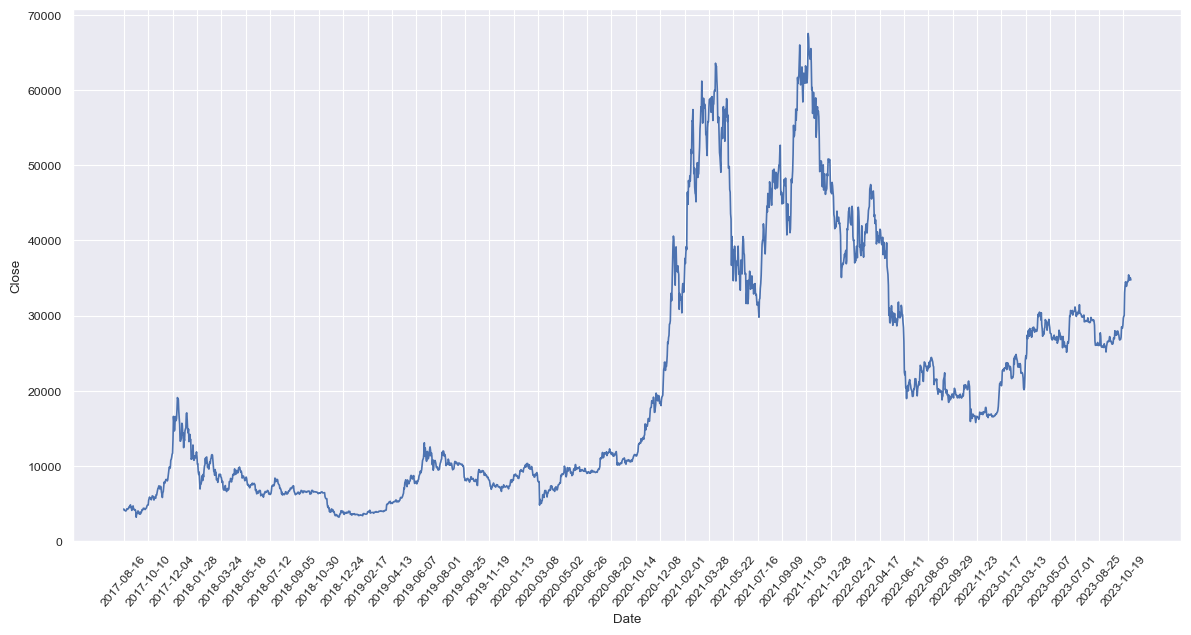

In [16]:
plt.figure(figsize = (12,6))
ax = sns.lineplot(data=BTC_df, x="Date", y="Close")
freq = int(55)
xtix = ax.get_xticks()
ax.set_xticks(xtix[::freq])
plt.tight_layout()
plt.xticks(rotation=50);


De gráfico anterior puede concluirse que en efecto la serie de tiempo no es estacionaria, sin embargo se realizará la prueba ADF para verificar dicha hipótesis. 

- Ho: No estacionariedad

- H1: Estacionariedad

In [17]:
result = adfuller(BTC_df.Close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.659405
p-value: 0.452140


Dado que el p-valor es mayor que el nivel de significancia (0.05), no se rechaza la hipótesis nula. La serie de tiempo es no estacionaria. 

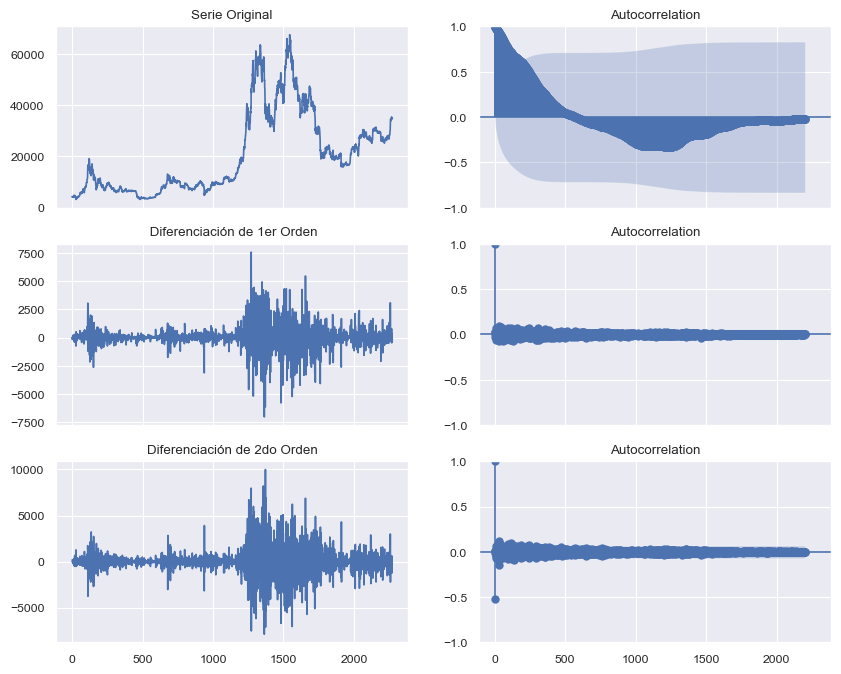

In [18]:
plt.rcParams.update({'figure.figsize': (10,8)})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(BTC_df.Close); axes[0, 0].set_title('Serie Original')
plot_acf(BTC_df.Close, ax=axes[0, 1], lags = 2200);

axes[1, 0].plot(BTC_df.Close.diff()); axes[1, 0].set_title(' Diferenciación de 1er Orden')
plot_acf(BTC_df.Close.diff().dropna(), ax=axes[1, 1], lags = 2200);

axes[2, 0].plot(BTC_df.Close.diff().diff()); axes[2, 0].set_title('Diferenciación de 2do Orden')
plot_acf(BTC_df.Close.diff().diff().dropna(), ax=axes[2, 1], lags = 2200);

 cuando analizamos el gráfico de autocorrelación para la segunda diferencia de la serie de tiempo, notamos que el retraso se vuelve negativo de manera rápida, sugiriendo que podríamos haber aplicado demasiadas diferenciaciones a la serie. Esto podría no ser necesario.

## MODELO ARIMA

In [19]:
# Definir los rangos de valores para p, d, q
p = range(5)  # Orden del componente autorregresivo
d = range(3)  # Orden de diferenciación
q = range(5)  # Orden del componente de media móvil

- Datos de entrenamiento + validación:

Se tomará un conjunto de 2244 datos para realizar el respectivo entrenamiento y validación del modelo arima.

In [20]:
N_BTC = len(BTC_df)
Train_size=N_BTC-28
Train_size

2245

- Datos de prueba:

Se fijara un conjunto de dados para prueba de tamaño 28  el cuals e usará para testear el mejor modelo en distintos horizontes (7,14,21,28), esto con el fin de comparar la generalización del modelo.

In [21]:
Test_size=N_BTC-Train_size
Test_size

28

### ENFOQUE ROLLING

El enfoque de rolling en ARIMA implica ajustar un modelo ARIMA a un subconjunto de los datos de la serie de tiempo y usar ese modelo para realizar pronósticos en un punto específico en el futuro. Luego, se desliza la ventana temporal hacia adelante en el tiempo, se ajusta un nuevo modelo ARIMA en el nuevo conjunto de datos dentro de la ventana y se realiza otro pronóstico. Esto se repite a lo largo de toda la serie de tiempo, lo que permite evaluar continuamente la calidad de las predicciones a medida que se avanza en el tiempo.

#### Criterio de Akaike (AIC)

In [22]:
def grid_search_ARIMA_AIC(serie,p,d,q):
    best_order_aic=None
    best_aic=float('inf')
    # Generar todas las combinaciones posibles de valores de p, d, q
    #los parámetros p (orden del componente autorregresivo),
    #  d (orden de diferenciación) y 
    # q (orden del componente de media móvil).
    orders=list(itertools.product(p,d,q))
    for order in orders:
        try:
            tmp_model=ARIMA(serie, order=order).fit()
            tm_aic = tmp_model.aic
            if tm_aic<best_aic:
                best_aic=tm_aic
                best_order_aic=order

        except:
            continue

    return best_order_aic,best_aic

In [23]:
hzt_values = [7, 14, 21,28]  # Valores de horizontes
n_BTC = Train_size

for n_test in hzt_values:
        
    train_size = n_BTC - n_test
    train = BTC_df.Close.iloc[:train_size]
    test = BTC_df.Close.iloc[train_size:train_size + n_test]


    print(f"Horizonte = {n_test}")
    print("train:", train.shape)
    print("test:", test.shape)
    
    # Definir los rangos de valores para p, d, q
    p = range(5)  # Orden del componente autorregresivo
    d = range(3)  # Orden de diferenciación
    q = range(5)  # Orden del componente de media móvil


    best_order_aic, best_aic = grid_search_ARIMA_AIC(train, p, d, q)
    
    print("Mejor modelo ARIMA basado en el criterio de Akaike:")
    print('AIC: {:6.5f} | order: {}'.format(best_aic, best_order_aic))




Horizonte = 7
train: (2238,)
test: (7,)


Mejor modelo ARIMA basado en el criterio de Akaike:
AIC: 37019.48659 | order: (4, 1, 3)
Horizonte = 14
train: (2231,)
test: (14,)
Mejor modelo ARIMA basado en el criterio de Akaike:
AIC: 36909.98091 | order: (2, 2, 3)
Horizonte = 21
train: (2224,)
test: (21,)
Mejor modelo ARIMA basado en el criterio de Akaike:
AIC: 36801.36944 | order: (2, 2, 3)
Horizonte = 28
train: (2217,)
test: (28,)
Mejor modelo ARIMA basado en el criterio de Akaike:
AIC: 36691.56045 | order: (2, 2, 3)


Estos resultados muestran que para diferentes horizontes de predicción, se han encontrado modelos ARIMA óptimos basados en el AIC. Los valores de AIC indican la calidad del ajuste del modelo, y en este caso, los modelos con menor AIC se consideran los mejores modelos para cada horizonte.

De los dos posibles modelos ARIMA encontrados, decidimos elegir el modelo (4,1,3) , ya que este no tiene orden 2 de diferenciación, y las gráficas de autocorrelación nos indican que una diferenciación de orden dos podría ser innecesaria. Vamos a utilizar este modelo para realizar predicciones en todos los horizontes de tiempo. Luego, evaluaremos el desempeño de las predicciones utilizando varias métricas, como el error absoluto porcentual medio (MAPE), el error absoluto medio (MAE), la raíz del error cuadrático medio (RMSE), el error cuadrático medio (MSE) y el coeficiente de determinación (R^2) para determinar qué tan bien se ajusta el modelo a los diferentes horizontes de predicción.

In [24]:
best_order_aic=(4,1,3)
best_order_aic

(4, 1, 3)

Horizonte = 7


<Figure size 800x600 with 0 Axes>

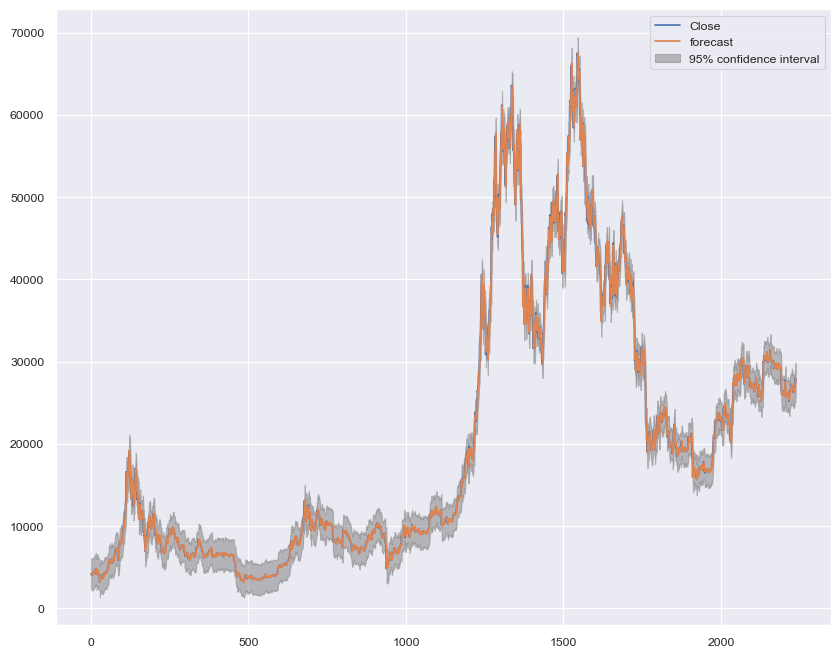

Horizonte = 14


<Figure size 800x600 with 0 Axes>

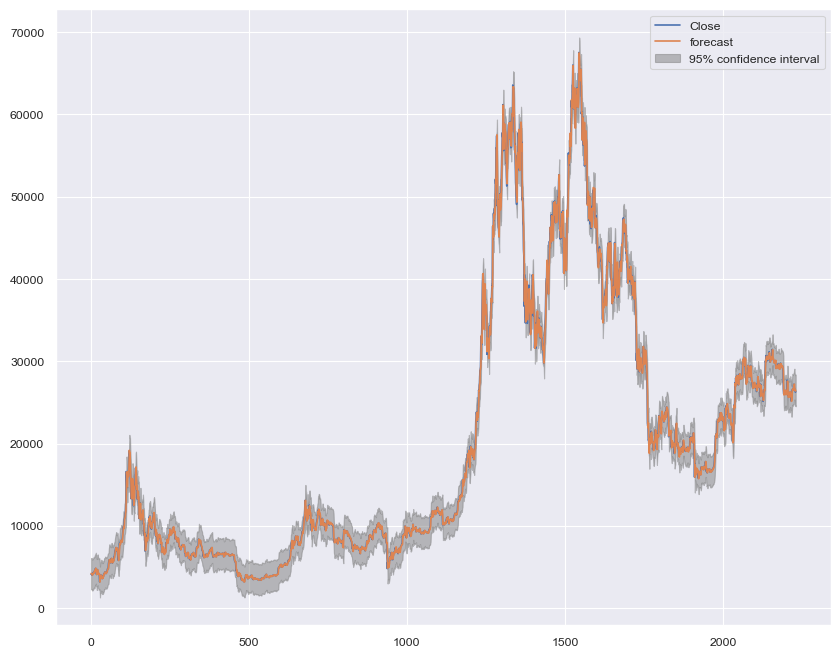

Horizonte = 21


<Figure size 800x600 with 0 Axes>

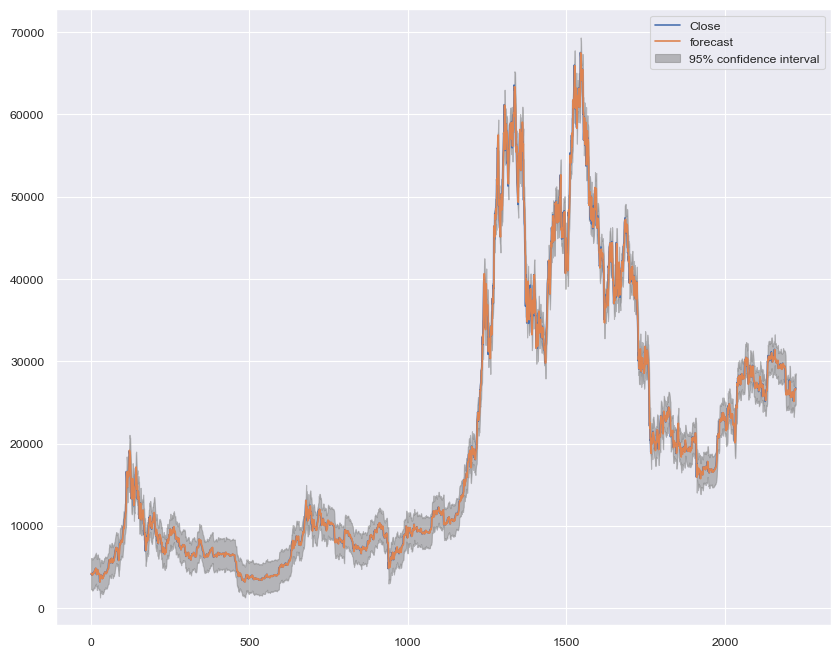

Horizonte = 28


<Figure size 800x600 with 0 Axes>

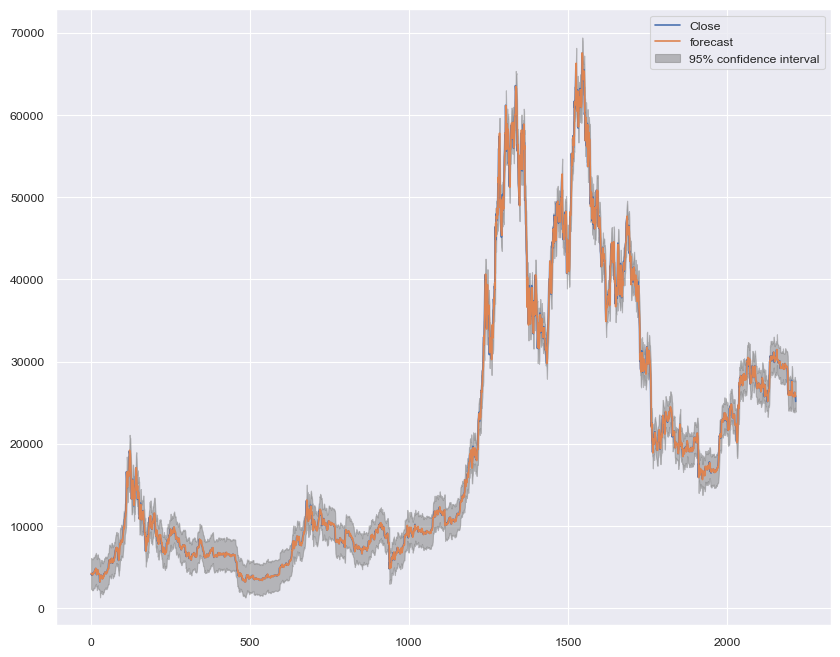

In [25]:
hzt_values = [7, 14, 21,28] 

for n_test in hzt_values:
    
    train_size = n_BTC - n_test
    train = BTC_df.Close.iloc[:train_size]

    print(f"Horizonte = {n_test}")
   
    model = ARIMA(train, order=best_order_aic)
    model_fit = model.fit()
    plt.figure(figsize = (8,6))
    fig, ax = plt.subplots()
    ax = train.loc[1:].plot(ax=ax)
    plot_predict(model_fit, 1, ax=ax)
    plt.show();

 los gráficos que se muestran en el código anterior muestran cómo se ajusta el modelo ARIMA a los datos de entrenamiento, pero para evaluar verdaderamente la calidad del modelo, es esencial probarlo con datos desconocidos (datos de prueba). La predicción y el ajuste del modelo en los datos de entrenamiento no son suficientes para determinar su capacidad de generalización y precisión en situaciones del mundo real.

In [26]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

In [27]:
def arima_rolling(history, test, best_o):
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_o)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

El siguiente código realiza la predición en los datos de prueba (cada horizonte) y, por medio de gráficos, nos muestra la comparación entre los datos predichos y los esperados.

In [28]:
Train_size

2245

In [29]:
Test_size

28

Horizonte = 7
predicted=27570.510318, expected=27390.120000
predicted=27299.758550, expected=26875.520000
predicted=26861.997748, expected=26759.630000
predicted=26755.727283, expected=26862.000000
predicted=26833.819131, expected=26852.480000
predicted=26862.299600, expected=27154.150000
predicted=27121.700848, expected=28500.780000
Horizonte = 14
predicted=27570.510318, expected=27390.120000
predicted=27299.758550, expected=26875.520000
predicted=26861.997748, expected=26759.630000
predicted=26755.727283, expected=26862.000000
predicted=26833.819131, expected=26852.480000
predicted=26862.299600, expected=27154.150000
predicted=27121.700848, expected=28500.780000
predicted=28494.553105, expected=28395.910000
predicted=28405.828805, expected=28320.000000
predicted=28313.805860, expected=28713.710000
predicted=28732.684061, expected=29669.040000
predicted=29652.987253, expected=29909.800000
predicted=29908.123373, expected=29992.460000
predicted=29976.730688, expected=33069.990000
Horiz

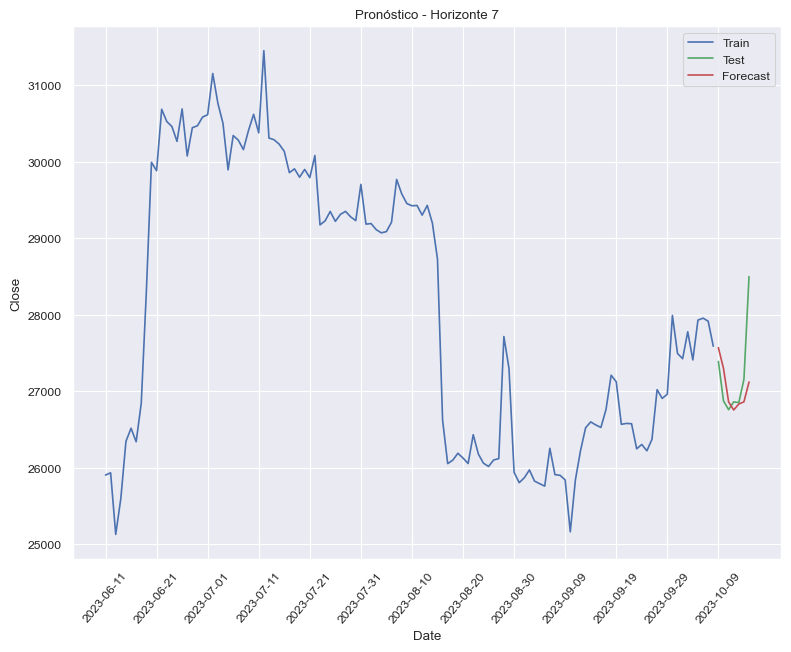

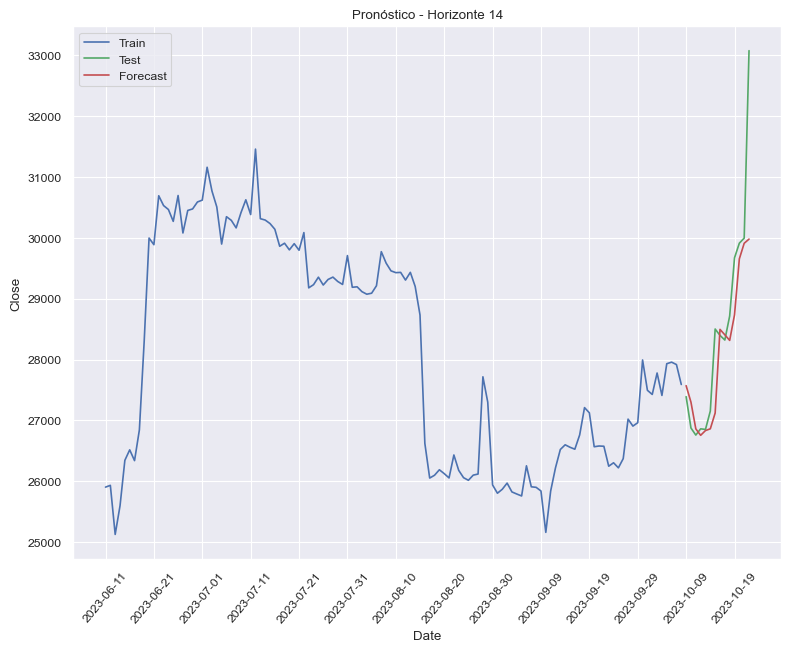

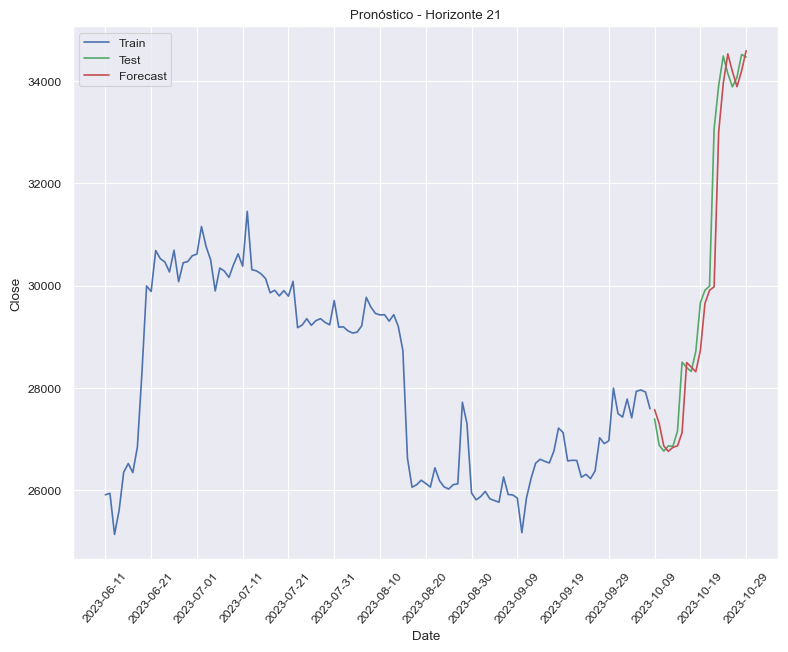

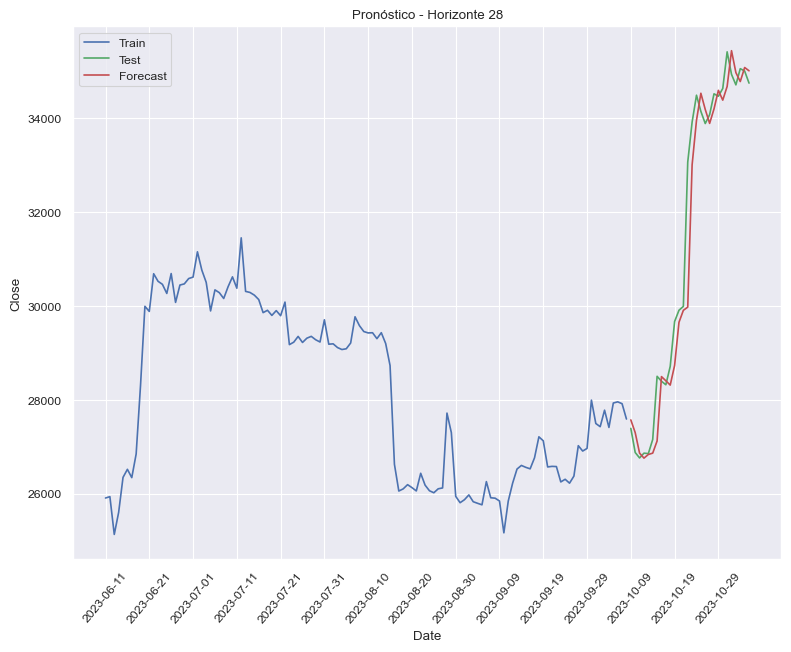

In [30]:
hzt_values = [7, 14, 21,28] 
results_AIC = pd.DataFrame(columns=['Horizonte', 'MAE', 'MSE', 'MAPE', 'RMSE', 'R2'])
row_index=0
for n_test in hzt_values:
    train_size = Train_size
    train = BTC_df.Close.iloc[:train_size]
    dates_train = BTC_df.Date.iloc[:train_size]
    test_1w = BTC_df.Close.iloc[train_size:train_size + n_test]
    dates_1w = BTC_df.Date.iloc[train_size:train_size + n_test]

    print(f"Horizonte = {n_test}")
    test_1wl = test_1w.tolist()
    yhat_1w  = arima_rolling(train.tolist(), test_1wl, best_order_aic)
    df_acc= forecast_accuracy(np.array(test_1wl), np.array(yhat_1w), n_test)
    results_AIC.loc[row_index] = [n_test, df_acc.iloc[0]['MAE'], df_acc.iloc[0]['MSE'], df_acc.iloc[0]['MAPE'], df_acc.iloc[0]['RMSE'], df_acc.iloc[0]['R2']]
    row_index += 1
    
    plt.figure(figsize = (8, 6))
    ax = sns.lineplot(x=dates_train[-120:], y=train[-120:], label="Train", color='b')
    sns.lineplot(x=dates_1w, y=test_1wl, label="Test", color='g')
    sns.lineplot(x=dates_1w, y=yhat_1w, label="Forecast", color='r')
    freq = int(10)
    xtix = ax.get_xticks()
    ax.set_xticks(xtix[::freq])
    plt.tight_layout()
    plt.xticks(rotation=50);
    plt.title(f"Pronóstico - Horizonte {n_test}")

- Métricas: A medida que aumenta el horizonte, el modelo explica un porcentaje mayor de la variabilidad de los datos:

In [31]:
results_AIC

,Horizonte,MAE,MSE,MAPE,RMSE,R2
0,7.0,357.551394,317382.321776,0.013182,563.366951,0.018911
1,14.0,532.714316,922626.977577,0.018581,960.534735,0.682192
2,21.0,486.925054,687084.662869,0.016287,828.905702,0.926331
3,28.0,449.657760,553884.790456,0.014635,744.234365,0.949179


#### Criterio de Información de Hannan-Quinn (HQIC)

In [32]:
def grid_search_ARIMA_HQIC(serie,p,d,q):
    best_order_hqic=None
    best_hqic=float('inf')
    # Generar todas las combinaciones posibles de valores de p, d, q
    #los parámetros p (orden del componente autorregresivo),
    #  d (orden de diferenciación) y 
    # q (orden del componente de media móvil).
    orders=list(itertools.product(p,d,q))
    for order in orders:
        try:
            tmp_model=ARIMA(serie, order=order).fit()
            tm_hqic = tmp_model.hqic
            if tm_hqic<best_hqic:
                best_hqic=tm_hqic
                best_order_hqic=order

        except:
            continue

    return best_order_hqic,best_hqic

In [33]:
Train_size

2245

In [34]:
hzt_values = [7, 14, 21,28]  # Valores de horizontes

for n_test in hzt_values:
    train_size = Train_size - n_test
    train = BTC_df.Close.iloc[:train_size]
    test = BTC_df.Close.iloc[train_size:train_size + n_test]

    print(f"Horizonte = {n_test}")
    print("train:", train.shape)
    print("test:", test.shape)
    
    # Definir los rangos de valores para p, d, q
    p = range(5)  # Orden del componente autorregresivo
    d = range(3)  # Orden de diferenciación
    q = range(5)  # Orden del componente de media móvil


    best_order_hqic, best_hqic= grid_search_ARIMA_HQIC(train, p, d, q)
    
    print("Mejor modelo ARIMA basado en el criterio de Información de Hannan-Quinn:")
    print('HQIC: {:6.5f} | order: {}'.format(best_hqic, best_order_hqic))

Horizonte = 7
train: (2238,)
test: (7,)


Mejor modelo ARIMA basado en el criterio de Información de Hannan-Quinn:
HQIC: 37036.17288 | order: (4, 1, 3)
Horizonte = 14
train: (2231,)
test: (14,)
Mejor modelo ARIMA basado en el criterio de Información de Hannan-Quinn:
HQIC: 36922.49005 | order: (2, 2, 3)
Horizonte = 21
train: (2224,)
test: (21,)
Mejor modelo ARIMA basado en el criterio de Información de Hannan-Quinn:
HQIC: 36813.87368 | order: (2, 2, 3)
Horizonte = 28
train: (2217,)
test: (28,)
Mejor modelo ARIMA basado en el criterio de Información de Hannan-Quinn:
HQIC: 36704.05978 | order: (2, 2, 3)


Vemos que ambos criterios de selección de modelos llegaron a las mismas dos opciones de modelos posibles. 

Hemos decidido considerar el modelo con orden de diferenciación 2 ya que nos interesa saber cual de los dos posibles modelos generaliza mejor y también si una segunda diferenciación mejora o no la predicción en la serie de tiempo. Vamos a utilizar este modelo para realizar predicciones en todos los horizontes de tiempo. Luego, evaluaremos el desempeño de las predicciones utilizando varias métricas, como el error absoluto porcentual medio (MAPE), el error absoluto medio (MAE), la raíz del error cuadrático medio (RMSE), el error cuadrático medio (MSE) y el coeficiente de determinación (R^2) para determinar qué tan bien se ajusta el modelo a los diferentes horizontes de predicción.

In [35]:
best_order_hqic

(2, 2, 3)

Horizonte = 7


<Figure size 800x600 with 0 Axes>

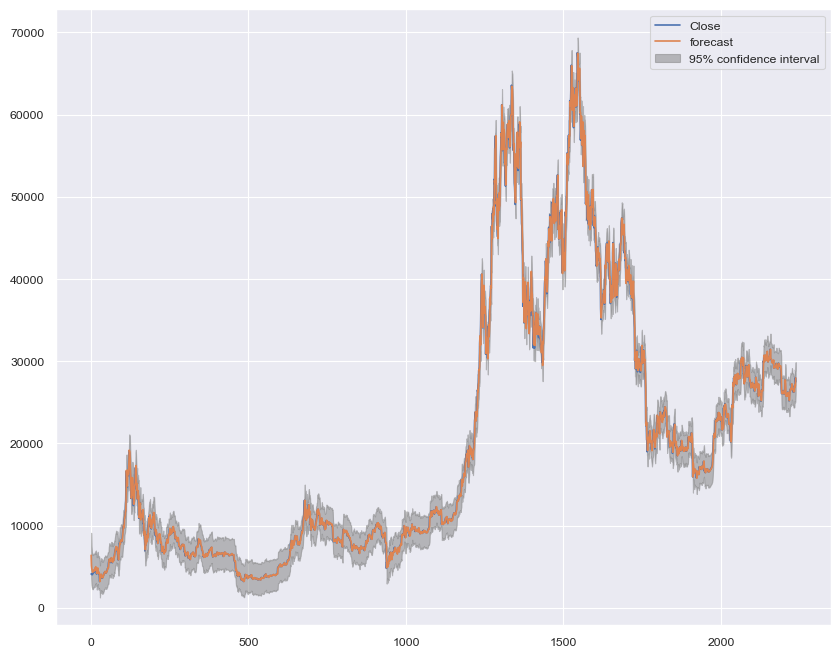

Horizonte = 14


<Figure size 800x600 with 0 Axes>

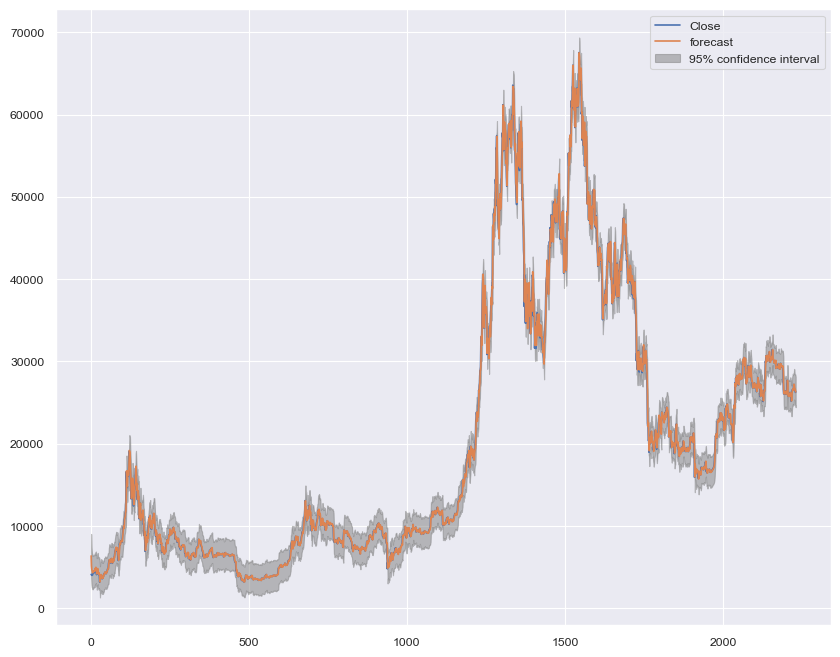

Horizonte = 21


<Figure size 800x600 with 0 Axes>

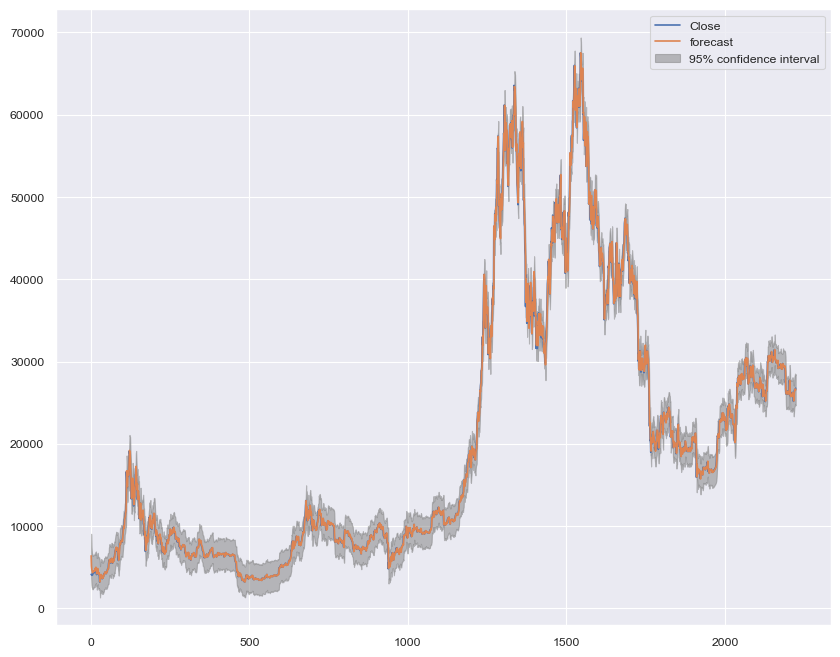

Horizonte = 28


<Figure size 800x600 with 0 Axes>

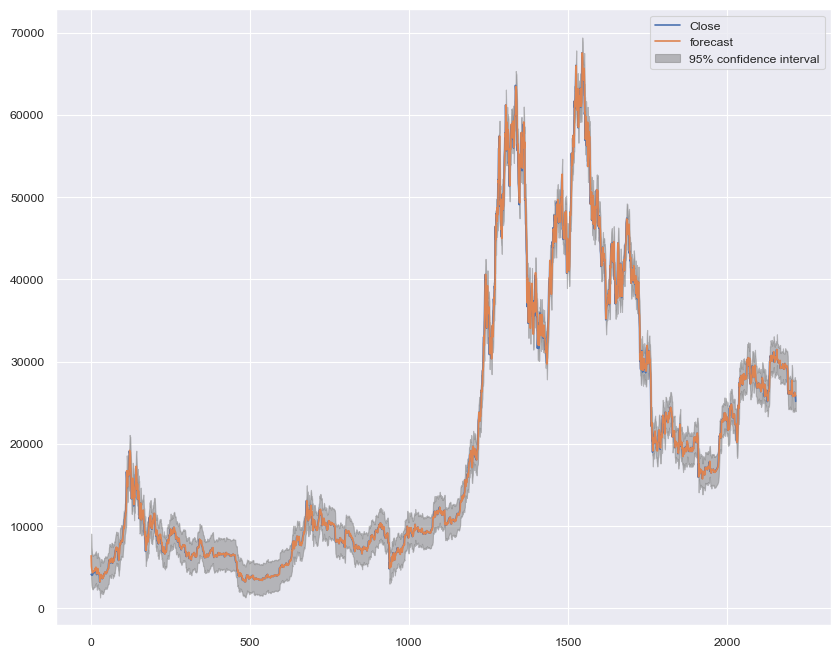

In [36]:
n_test_values = [7, 14, 21,28]  
for n_test in n_test_values:
    train_size = n_BTC - n_test
    train = BTC_df.Close.iloc[:train_size]

    print(f"Horizonte = {n_test}")
   
    model = ARIMA(train, order=best_order_hqic)
    model_fit = model.fit()
    plt.figure(figsize = (8,6))
    fig, ax = plt.subplots()
    ax = train.loc[1:].plot(ax=ax)
    plot_predict(model_fit, 1, ax=ax)
    plt.show();

Horizonte = 7
predicted=27603.525906, expected=27390.120000
predicted=27361.499183, expected=26875.520000
predicted=26926.693278, expected=26759.630000
predicted=26732.963733, expected=26862.000000
predicted=26877.742176, expected=26852.480000
predicted=26848.924788, expected=27154.150000
predicted=27135.944747, expected=28500.780000
Horizonte = 14
predicted=27603.525906, expected=27390.120000
predicted=27361.499183, expected=26875.520000
predicted=26926.693278, expected=26759.630000
predicted=26732.963733, expected=26862.000000
predicted=26877.742176, expected=26852.480000
predicted=26848.924788, expected=27154.150000
predicted=27135.944747, expected=28500.780000
predicted=28524.312814, expected=28395.910000
predicted=28388.223859, expected=28320.000000
predicted=28361.480455, expected=28713.710000
predicted=28695.988803, expected=29669.040000
predicted=29704.490164, expected=29909.800000
predicted=29878.685382, expected=29992.460000
predicted=30045.658025, expected=33069.990000
Horiz

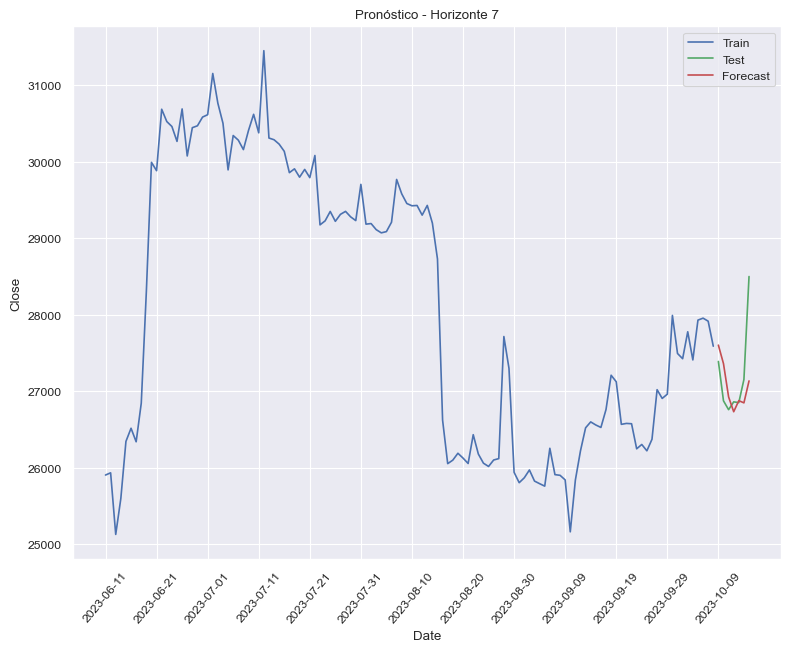

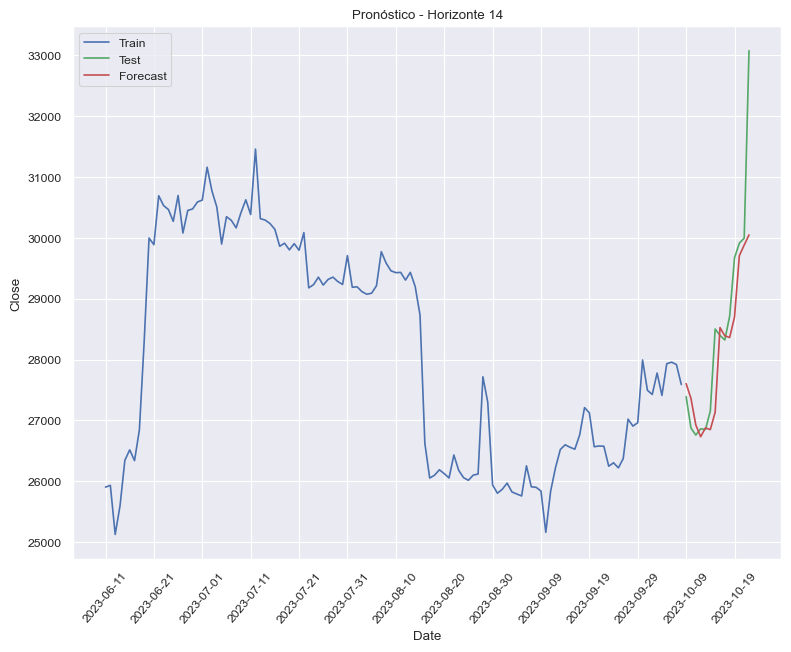

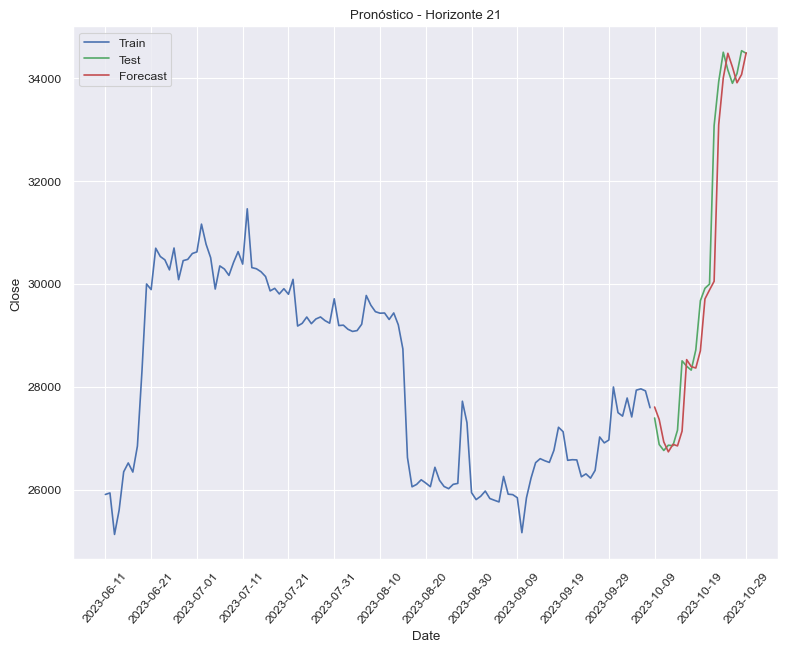

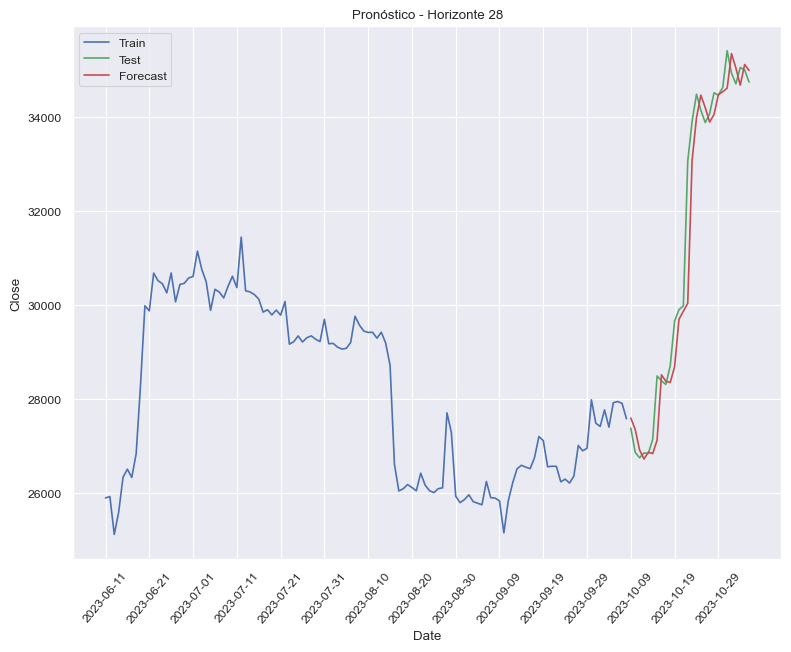

In [37]:
n_test_values = [7, 14, 21,28]  
result_HQIC = pd.DataFrame(columns=['Horizonte', 'MAE', 'MSE', 'MAPE', 'RMSE', 'R2'])
row_index=0
for n_test in n_test_values:
    
    train_size = Train_size
    train = BTC_df.Close.iloc[:train_size]
    dates_train = BTC_df.Date.iloc[:train_size]
    test_1w = BTC_df.Close.iloc[train_size:train_size + n_test] 
    dates_1w = BTC_df.Date.iloc[train_size:train_size + n_test]

    print(f"Horizonte = {n_test}")
    test_1wl = test_1w.tolist()
    yhat_1w  = arima_rolling(train.tolist(), test_1wl, best_order_hqic)
    df_acc= forecast_accuracy(np.array(test_1wl), np.array(yhat_1w), n_test)
    result_HQIC.loc[row_index] = [n_test, df_acc.iloc[0]['MAE'], df_acc.iloc[0]['MSE'], df_acc.iloc[0]['MAPE'], df_acc.iloc[0]['RMSE'], df_acc.iloc[0]['R2']]
    row_index += 1
    
    plt.figure(figsize = (8, 6))
    ax = sns.lineplot(x=dates_train[-120:], y=train[-120:], label="Train", color='b')
    sns.lineplot(x=dates_1w, y=test_1wl, label="Test", color='g')
    sns.lineplot(x=dates_1w, y=yhat_1w, label="Forecast", color='r')
    freq = int(10)
    xtix = ax.get_xticks()
    ax.set_xticks(xtix[::freq])
    plt.tight_layout()
    plt.xticks(rotation=50);
    plt.title(f"Pronóstico - Horizonte {n_test}")

In [38]:
result_HQIC

,Horizonte,MAE,MSE,MAPE,RMSE,R2
0,7.0,384.401039,326122.031461,0.014161,571.070951,-0.008105
1,14.0,539.723651,898326.497826,0.018838,947.800875,0.690562
2,21.0,484.966230,665608.056796,0.016263,815.848060,0.928634
3,28.0,448.721671,540204.778579,0.014634,734.986244,0.950434


- El coeficiente de determinación (R2) también aumenta, no debería ser así, ya que  a medida que el horizonte aumenta el porcentaje de varianza explicada debería disminuir. Aparentemente una segunda diferenciación es innecesaria, puesto que se obtuvieron resultados similares que al usar un modelo de orden 1. Se propone el no uso de la técnica rolling para verificar los resultados obtenidos en dichas métricas. 


#### Prueba de normalidad en los residuos

- Criterio de Akaike:

In [39]:
def arima_rolling_error(history, test, best_or):
    error_aic=list()
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_or)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        error_aic.append(obs - yhat)
        #prueba de normalidad en los residuales (Shapiro-Wilk)
    stat, p_value = stats.shapiro(error_aic)
    print(f"Estadístico de prueba de normalidad: {stat}")
    print(f"Valor p: {p_value}")
    alpha = 0.05 
    if p_value > alpha:
        print("Los residuales siguen una distribución normal (no se rechaza H0)")
    else:
        print("Los residuales no siguen una distribución normal (se rechaza H0)")
    
    return error_aic

In [40]:
n_test_values = [7, 14, 21,28]  
for n_test in n_test_values:
    
    train_size = Train_size
    train = BTC_df.Close.iloc[:train_size]
    test_1w = BTC_df.Close.iloc[train_size:train_size + n_test] 
    

    print(f"Horizonte = {n_test}")
    test_1wl = test_1w.tolist()
    error_aic  = arima_rolling_error(train.tolist(), test_1wl, best_order_aic)

Horizonte = 7
Estadístico de prueba de normalidad: 0.8186613917350769
Valor p: 0.06233812868595123
Los residuales siguen una distribución normal (no se rechaza H0)
Horizonte = 14
Estadístico de prueba de normalidad: 0.7249640226364136
Valor p: 0.0006784417200833559
Los residuales no siguen una distribución normal (se rechaza H0)
Horizonte = 21
Estadístico de prueba de normalidad: 0.7494720220565796
Valor p: 0.00012189211702207103
Los residuales no siguen una distribución normal (se rechaza H0)
Horizonte = 28
Estadístico de prueba de normalidad: 0.7586357593536377
Valor p: 2.1611831471091136e-05
Los residuales no siguen una distribución normal (se rechaza H0)


- Criterio de Información de Hannan-Quinn (HQIC)

In [41]:
def arima_rolling1_error(history, test, best_or):
    error_hqic=list()
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_or)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        error_hqic.append(obs - yhat)
        #prueba de normalidad en los residuales (Shapiro-Wilk)
    stat, p_value = stats.shapiro(error_hqic)
    print(f"Estadístico de prueba de normalidad: {stat}")
    print(f"Valor p: {p_value}")
    alpha = 0.05 
    if p_value > alpha:
        print("Los residuales siguen una distribución normal (no se rechaza H0)")
    else:
        print("Los residuales no siguen una distribución normal (se rechaza H0)")
    
    return error_hqic

In [42]:
n_test_values = [7, 14, 21,28]  
for n_test in n_test_values:
    
    train_size = Train_size
    train = BTC_df.Close.iloc[:train_size]
    test_1w = BTC_df.Close.iloc[train_size:train_size + n_test] 

    print(f"Horizonte = {n_test}")
    test_1wl = test_1w.tolist()
    yhat_1w  = arima_rolling1_error(train.tolist(), test_1wl, best_order_hqic)

Horizonte = 7
Estadístico de prueba de normalidad: 0.8444534540176392
Valor p: 0.10928093641996384
Los residuales siguen una distribución normal (no se rechaza H0)
Horizonte = 14
Estadístico de prueba de normalidad: 0.7444614171981812
Valor p: 0.0011107135796919465
Los residuales no siguen una distribución normal (se rechaza H0)
Horizonte = 21
Estadístico de prueba de normalidad: 0.7654687166213989
Valor p: 0.00020364813099149615
Los residuales no siguen una distribución normal (se rechaza H0)
Horizonte = 28
Estadístico de prueba de normalidad: 0.7679306864738464
Valor p: 3.052919055335224e-05
Los residuales no siguen una distribución normal (se rechaza H0)


### ENFOQUE SIN ROLLING

#### Criterio de Akaike (AIC)

En la sección anterior se determinó los mejores hiperparámetros para el modelo ARIMA con menor AIC. A continuación, se realizará el ajuste y evaluación de este modelo para todos los horizontes sin aplicar la técnica rolling, se espera obtener una apropiada evaluación de la generalización del modelo según las métricas establecidas anteriormente. 

In [43]:
best_order_aic

(4, 1, 3)

In [44]:
def arima_sin_rolling(history, test, best_o):
    model = ARIMA(history, order=best_o)
    model_fit = model.fit()
    output = model_fit.forecast(steps=len(test))
    predictions=list()
    for t in range(len(test)):
        predictions.append(output[t])      
        print('predicted=%f, expected=%f' % (output[t], test[t]))
    return predictions

Horizonte = 7
predicted=27570.510318, expected=27390.120000
predicted=27561.186563, expected=26875.520000
predicted=27602.057287, expected=26759.630000
predicted=27591.127807, expected=26862.000000
predicted=27559.861940, expected=26852.480000
predicted=27590.725546, expected=27154.150000
predicted=27606.376554, expected=28500.780000
Horizonte = 14
predicted=27570.510318, expected=27390.120000
predicted=27561.186563, expected=26875.520000
predicted=27602.057287, expected=26759.630000
predicted=27591.127807, expected=26862.000000
predicted=27559.861940, expected=26852.480000
predicted=27590.725546, expected=27154.150000
predicted=27606.376554, expected=28500.780000
predicted=27569.027467, expected=28395.910000
predicted=27576.241375, expected=28320.000000
predicted=27610.446335, expected=28713.710000
predicted=27585.337078, expected=29669.040000
predicted=27566.805766, expected=29909.800000
predicted=27602.929064, expected=29992.460000
predicted=27601.704597, expected=33069.990000
Horiz

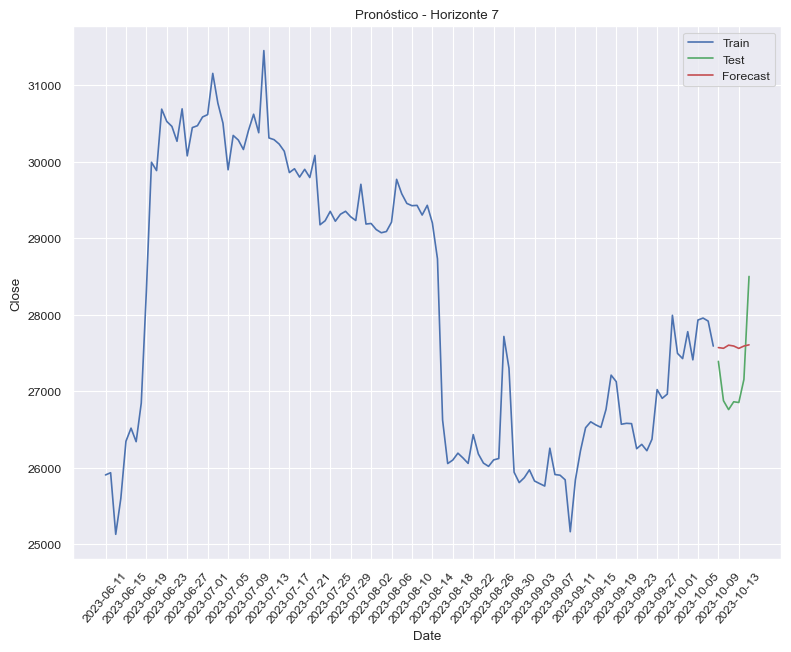

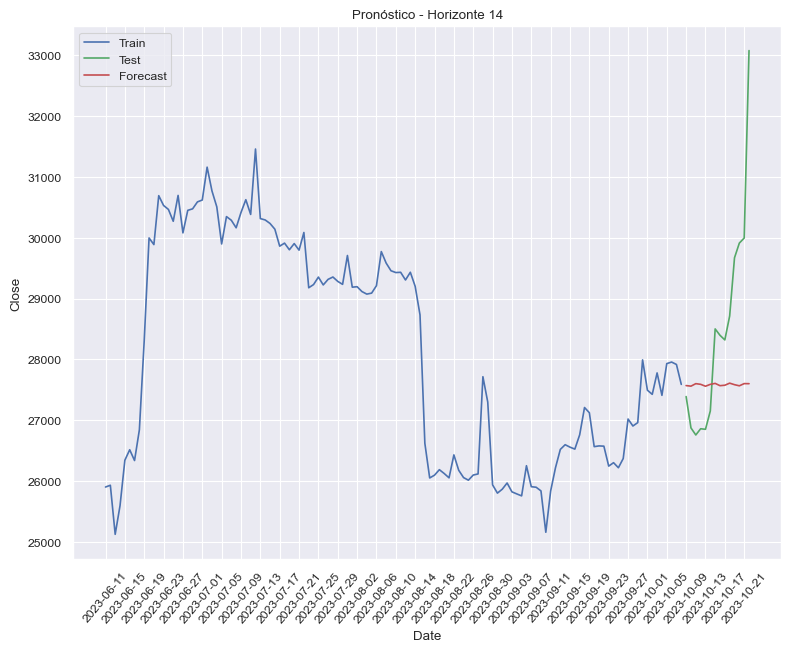

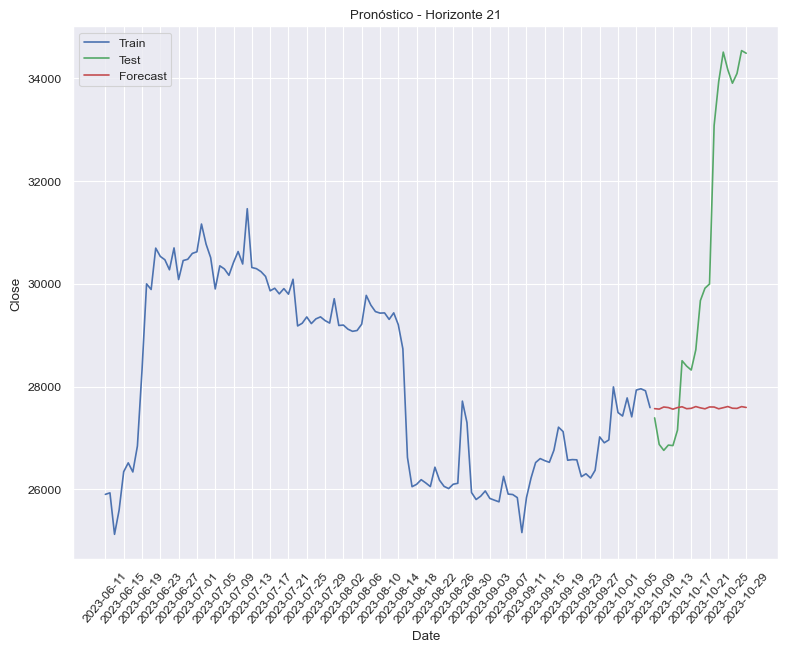

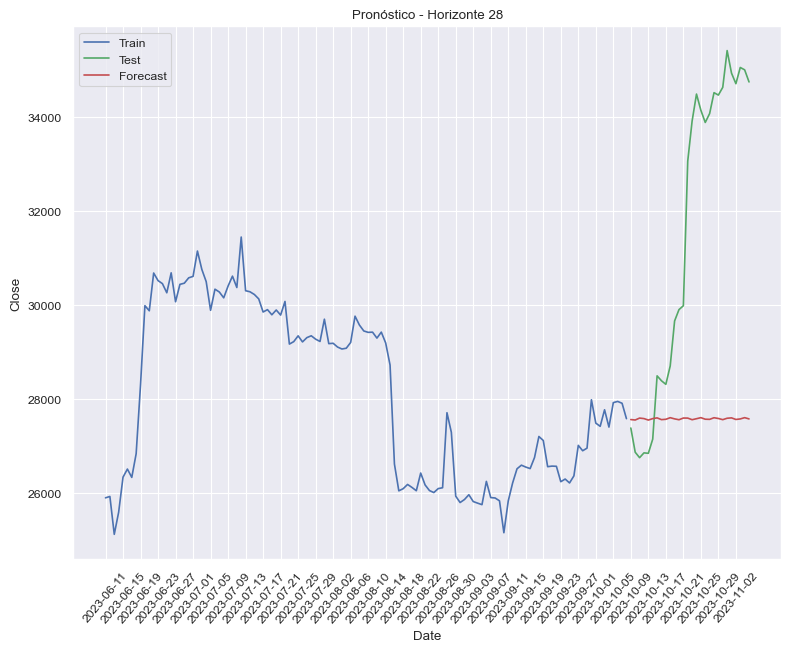

In [45]:
n_test_values = [7, 14, 21,28]  
result_AIC_2 = pd.DataFrame(columns=['Horizonte', 'MAE', 'MSE', 'MAPE', 'RMSE', 'R2'])
row_index=0
for n_test in n_test_values:
    
    train_size = Train_size
    train = BTC_df.Close.iloc[:train_size]
    dates_train = BTC_df.Date.iloc[:train_size]
    test_1w = BTC_df.Close.iloc[train_size:train_size + n_test] 
    dates_1w = BTC_df.Date.iloc[train_size:train_size + n_test]

    print(f"Horizonte = {n_test}")
    test_1wl = test_1w.tolist()
    yhat_1w  = arima_sin_rolling(train.tolist(), test_1wl, best_order_aic)
    df_acc= forecast_accuracy(np.array(test_1wl), np.array(yhat_1w), n_test)
    result_AIC_2.loc[row_index] = [n_test, df_acc.iloc[0]['MAE'], df_acc.iloc[0]['MSE'], df_acc.iloc[0]['MAPE'], df_acc.iloc[0]['RMSE'], df_acc.iloc[0]['R2']]
    row_index += 1
    
    plt.figure(figsize = (8, 6))
    ax = sns.lineplot(x=dates_train[-120:], y=train[-120:], label="Train", color='b')
    sns.lineplot(x=dates_1w, y=test_1wl, label="Test", color='g')
    sns.lineplot(x=dates_1w, y=yhat_1w, label="Forecast", color='r')
    freq = int(4)
    xtix = ax.get_xticks()
    ax.set_xticks(xtix[::freq])
    plt.tight_layout()
    plt.xticks(rotation=50);
    plt.title(f"Pronóstico - Horizonte {n_test}")

In [46]:
result_AIC_2

,Horizonte,MAE,MSE,MAPE,RMSE,R2
0,7.0,639.424701,4.621336e+05,0.023179,679.804104,-0.428543
1,14.0,1388.170802,3.652320e+06,0.050314,1911.104409,-0.258080
2,21.0,3135.980273,1.711429e+07,0.113665,4136.941974,-0.834987
3,28.0,4188.473947,2.634060e+07,0.151813,5132.309126,-1.416844


#### Criterio de Información de Hannan-Quinn (HQIC)

En la sección anterior se determinó los mejores hiperparámetros para el modelo ARIMA con menor HQIC. A continuación, se realizará el ajuste y evaluación de este modelo para todos los horizontes sin aplicar la técnica rolling, se espera obtener una apropiada evaluación de la generalización del modelo según las métricas establecidas anteriormente.

In [47]:
best_order_hqic

(2, 2, 3)

Horizonte = 7
predicted=27603.525906, expected=27390.120000
predicted=27608.779308, expected=26875.520000
predicted=27629.263275, expected=26759.630000
predicted=27629.291662, expected=26862.000000
predicted=27652.622105, expected=26852.480000
predicted=27652.433588, expected=27154.150000
predicted=27673.395265, expected=28500.780000
Horizonte = 14
predicted=27603.525906, expected=27390.120000
predicted=27608.779308, expected=26875.520000
predicted=27629.263275, expected=26759.630000
predicted=27629.291662, expected=26862.000000
predicted=27652.622105, expected=26852.480000
predicted=27652.433588, expected=27154.150000
predicted=27673.395265, expected=28500.780000
predicted=27677.834760, expected=28395.910000
predicted=27692.475044, expected=28320.000000
predicted=27704.192245, expected=28713.710000
predicted=27711.421512, expected=29669.040000
predicted=27729.866604, expected=29909.800000
predicted=27731.771585, expected=29992.460000
predicted=27753.589405, expected=33069.990000
Horiz

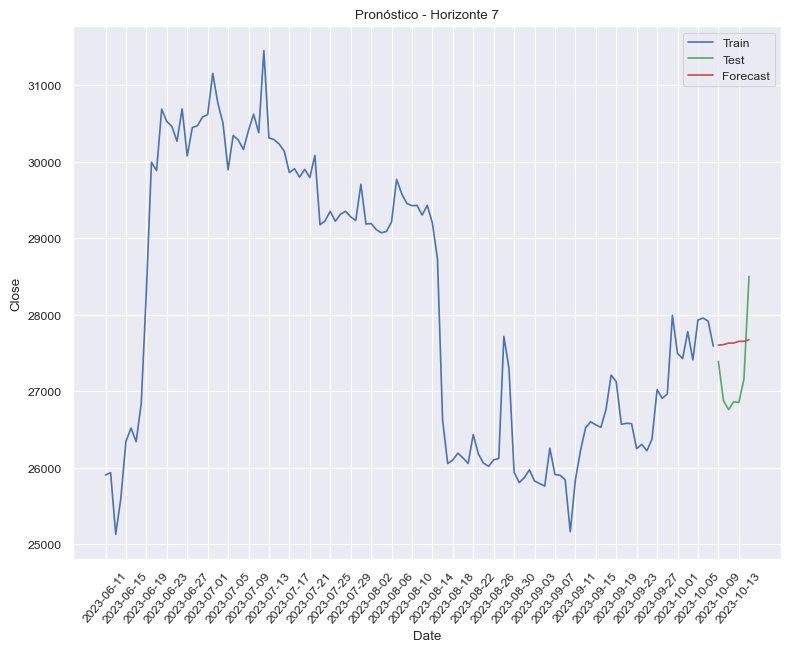

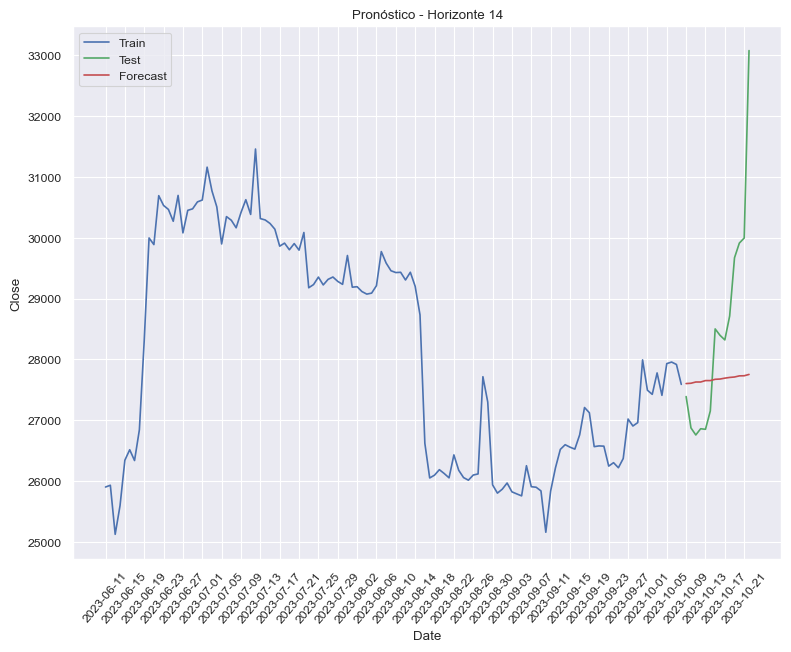

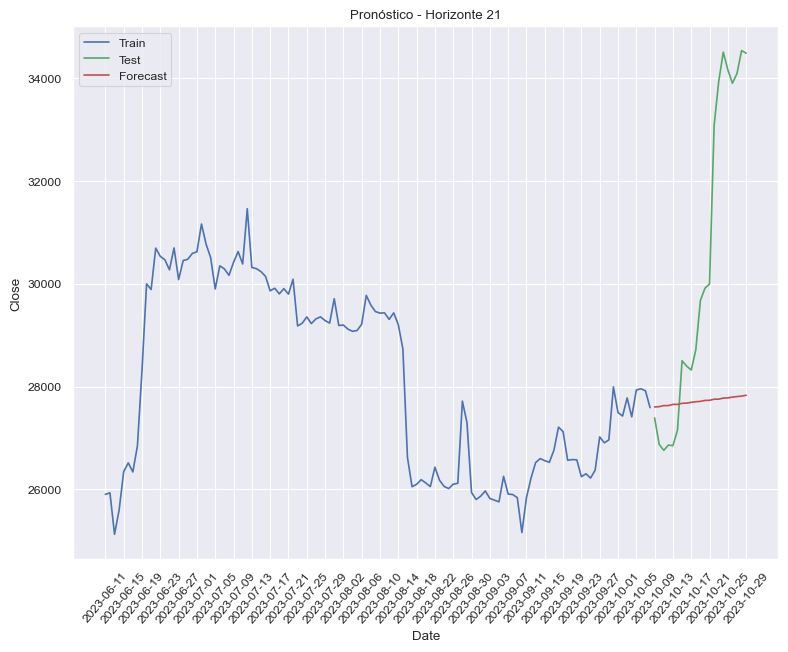

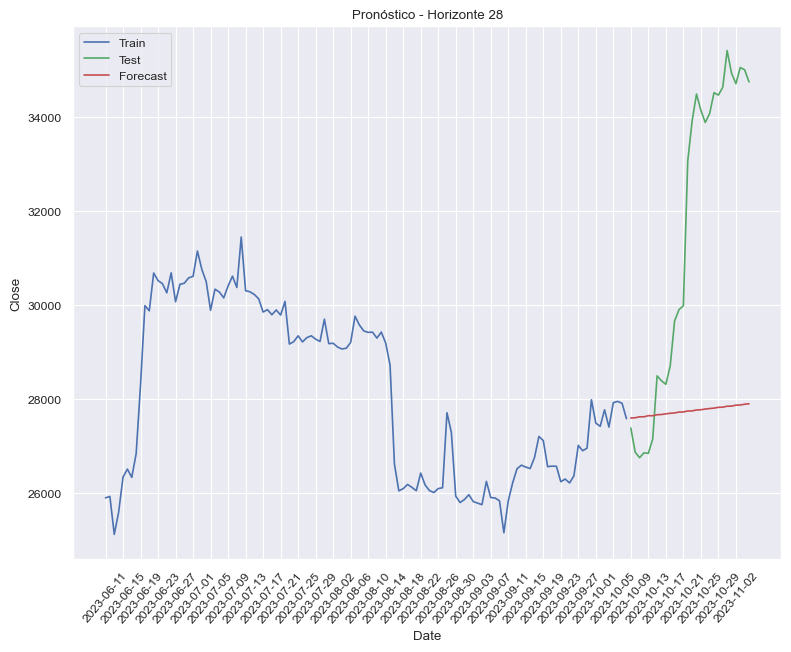

In [48]:
n_test_values = [7, 14, 21,28]  
result_HQIC_2 = pd.DataFrame(columns=['Horizonte', 'MAE', 'MSE', 'MAPE', 'RMSE', 'R2'])
row_index=0
for n_test in n_test_values:
    
    train_size = Train_size
    train = BTC_df.Close.iloc[:train_size]
    dates_train = BTC_df.Date.iloc[:train_size]
    test_1w = BTC_df.Close.iloc[train_size:train_size + n_test] 
    dates_1w = BTC_df.Date.iloc[train_size:train_size + n_test]

    print(f"Horizonte = {n_test}")
    test_1wl = test_1w.tolist()
    yhat_1w  = arima_sin_rolling(train.tolist(), test_1wl, best_order_hqic)
    df_acc= forecast_accuracy(np.array(test_1wl), np.array(yhat_1w), n_test)
    result_HQIC_2.loc[row_index] = [n_test, df_acc.iloc[0]['MAE'], df_acc.iloc[0]['MSE'], df_acc.iloc[0]['MAPE'], df_acc.iloc[0]['RMSE'], df_acc.iloc[0]['R2']]
    row_index += 1
    
    plt.figure(figsize = (8, 6))
    ax = sns.lineplot(x=dates_train[-120:], y=train[-120:], label="Train", color='b')
    sns.lineplot(x=dates_1w, y=test_1wl, label="Test", color='g')
    sns.lineplot(x=dates_1w, y=yhat_1w, label="Forecast", color='r')
    freq = int(4)
    xtix = ax.get_xticks()
    ax.set_xticks(xtix[::freq])
    plt.tight_layout()
    plt.xticks(rotation=50);
    plt.title(f"Pronóstico - Horizonte {n_test}")

In [49]:
result_HQIC_2

,Horizonte,MAE,MSE,MAPE,RMSE,R2
0,7.0,672.771512,5.001842e+05,0.024341,707.237003,-0.546165
1,14.0,1341.368530,3.384932e+06,0.048412,1839.818355,-0.165975
2,21.0,3036.692653,1.604668e+07,0.109359,4005.830301,-0.720518
3,28.0,4043.340184,2.452297e+07,0.145374,4952.066748,-1.250070


## CONCLUSIONES

- Se excluyó el criterio BIC ya que no arrojaba modelos que tuvieran sentido de implementar. Se verificó si la función estaba llamando correctamente el BIC y en efecto sí, pero los modelos propuestos siempre eran con orden (0,1,0).

- Se consideró como criterio el HQIC para la selección de mejores modelos ARIMA y se realizó la comparación con los propuestos por el criterio AIC.

- se realizó la evaluación de las métricas haciendo rolling y sin rolling también. se encontró que los modelos propuestos no tienen una buena generalización. 

- Los residuos no siguen una distribución normal para los horizontes diferentes a 7. Se propone considerar alguna transformación de los datos , como también otro posible modelo para pronostico de la serie de tiempo.